In [381]:
pwd()

"/home/xlx0727/Scripts/Statistic/qgplsim"

# Start

In [169]:
# run this ceil if source codes was edited
include("DGP.ji")
include("qgplsim.ji")
using Statistics, LinearAlgebra
using LaTeXStrings

import Base.Threads.@threads

# QGPLSIM fitting

In [271]:
# run this ceil for different data sets

α = [1.0, -0.5] # single index for x
θ = [1.0, 2.0] # linear for x, <α, θ> = 0 for identification
γ = [1.0, 0.0001] # single index for z
β = [0.5, -1.0] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)

n = 250
fx = 1 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ
ifz = true # if false, Z = 0, i.e. no category varible
X, Z, y = dgp(n, γ, θ, α, β, fx, ifz)
# p = length(α)
# q = length(γ)
τ = 0.5

# Estimation 

model1 = qgplsim.model(X, Z, y, τ)
alpha_type = 1
# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha, theta, gamma, beta = qgplsim.estimator(model1, alpha_type)
coefa = 1 / alpha[1]
coefg = 1 / gamma[1]
println("Estimation of index coefs: ")
println("̂α => ", coefa * alpha)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

theta * alpha

  0.919688 seconds (1.72 M allocations: 2.105 GiB, 38.01% gc time)
Estimation of index coefs: 
̂α => [1.0, -0.2586958863958619]
̂γ => [1.2777738599515518, 0.15040124314614722]
Estimation of linear coefs: 
̂θ => [0.586226375436515 2.2660830970441452]
̂β => [0.3336280850076767, -0.6119146126951365]


1-element Vector{Float64}:
 -1.1102230246251565e-16

In [57]:
a = ones(3, 1) * 2
b = ones(1, 2) * 3
kron(a, b)

3×2 Matrix{Float64}:
 6.0  6.0
 6.0  6.0
 6.0  6.0

In [58]:
norm([3,4], 2)

5.0

# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

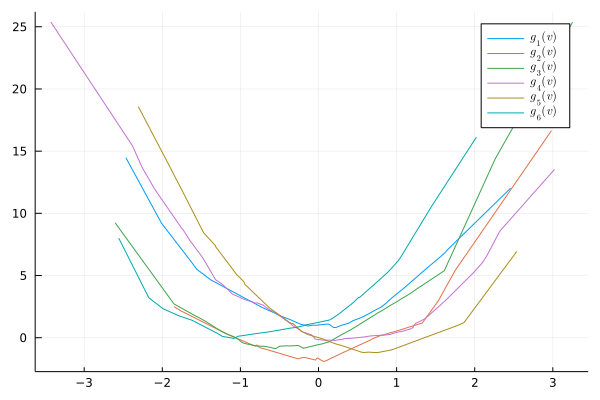

In [59]:
using Plots

v = X * alpha # g(Xα + Zγ) => univar func. g(v + zγ) after α was determined and  Z = z
categ, index = model1.categ, model1.index
g, dg = qgplsim.Gz_DGz(v, Z, y) # g: g(v), dg: g'(v)
fig = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]

    plot!(fig, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")

end
fig

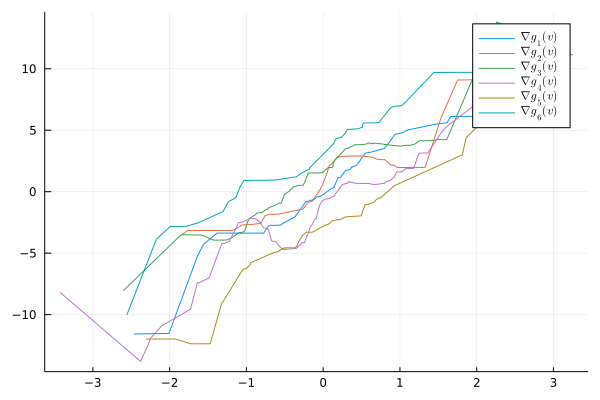

In [60]:
fig = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_vm = vm[indm]
    plot!(fig, sorted_vm, sorted_dgm, label = L"\nabla g_{%$m} (v)")

end
fig

# Monte Carlo Simulation

In [294]:
include("MonteCarloSIM.ji")

simulation (generic function with 1 method)

In [295]:
using DataFrames
df = DataFrame(α1 = Float64[], α2 = Float64[],
               var_α1 = Float64[], var_α2 = Float64[],    
               θ1 = Float64[], θ2 = Float64[],
               var_θ1 = Float64[], var_θ2 = Float64[], 
               β1 = Float64[], β2 = Float64[],
               var_β1 = Float64[], var_β2 = Float64[], 
               γ1 = Float64[], γ2 = Float64[],
               var_γ1 = Float64[], var_γ2 = Float64[])


,α1,α2,var_α1,var_α2,θ1,θ2,var_θ1,var_θ2,β1
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64


In [296]:
A = [:α1, :α2, :var_α1, :var_α2]
T = [:θ1, :θ2, :var_θ1, :var_θ2]
G = [:γ1, :γ2, :var_γ1, :var_γ2]
B = [:β1, :β2, :var_β1, :var_β2]

4-element Vector{Symbol}:
 :β1
 :β2
 :var_β1
 :var_β2

In [288]:
Threads.nthreads()

4

## y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ

In [283]:
α = [1.0, 0.5] # single index for x
θ = [1.0, -2.0]  # linear for x, <α, θ> = 0 for identification
# γ = [1.0, 0.5] # single index for z
β = [1.0, -0.5] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 100
alpha_type = 1

@threads for γ in [[1.0, 0.5], [1.0, 0.0], [0.0, 1.0], [0.5, 1.0], [0.0001, 0.0001]]
    res =  MonteCarlo(n, γ, θ, α, β, alpha_type)
    push!(df, res)
end
df[!, vcat(A, G)]

MC Computing time: 521.5802159309387
MC Computing time: 523.5872631072998
MC Computing time: 526.0826170444489
MC Computing time: 539.4305438995361
MC Computing time: 255.57478094100952


,α1,α2,var_α1,var_α2,γ1,γ2,var_γ1,var_γ2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.769956,0.23961,0.0745152,0.278773,0.117021,0.0718459,0.0376507,0.0210359
2,0.769248,0.35475,0.0693929,0.215869,0.587017,1.26447,0.0825524,0.14479
3,0.794999,0.238805,0.0512013,0.262889,0.0259497,1.18088,0.070409,0.235565
4,0.829267,0.364897,0.0373176,0.143658,1.24548,0.669244,0.135667,0.0448479
5,0.776159,0.249363,0.0651268,0.273656,1.2005,0.0153997,0.16452,0.019318
6,0.816007,0.320876,0.050611,0.182894,0.525849,1.1199,0.0733644,0.0935761
7,0.7558,0.358768,0.0699287,0.233154,0.133374,0.038844,0.0321238,0.018697
8,0.779757,0.304593,0.045611,0.256613,-0.000303224,1.0913,0.0527916,0.143264
9,0.801706,0.326026,0.0482184,0.205291,1.10208,0.56377,0.0895077,0.0447879


In [289]:
using CSV


In [290]:
CSV.write("gamma.csv", df)

"gamma.csv"